In [27]:
# ============================================================
# Phase-3: Expert System as a Training-time Prior
# ============================================================

import os, random, time
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

In [28]:
# ============================================================
# CONFIG
# ============================================================
class CFG:
    DATASET = "ALL"  # NIH | CHEXPERT | MIMIC | ALL

    # dataset roots
    NIH_IMAGE_ROOTS = [f"/kaggle/input/data/images_{i:03d}" for i in range(1,13)]
    NIH_CSV = "/kaggle/input/data/Data_Entry_2017.csv"
    CHEXPERT_TRAIN_DIR = "/kaggle/input/chexpert/CheXpert-v1.0-small/train"
    CHEXPERT_VALID_DIR = "/kaggle/input/chexpert/CheXpert-v1.0-small/valid"
    CHEXPERT_TRAIN_CSV = "/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv"
    CHEXPERT_VALID_CSV = "/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv"
    MIMIC_TRAIN_CSV = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_train.csv"
    MIMIC_VAL_CSV = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_validate.csv"

    SSL_BACKBONE_PATH = "/kaggle/input/phase-1-output-vayishu/ssl_backbone.pt"
    FINETUNED_MODEL_PATH = "/kaggle/working/phase2_checkpoints/finetuned_model.pt"

    BACKBONE = "resnet18"
    IMAGE_SIZE = 224
    TARGET_COLUMNS = [
        "Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion",
        "Emphysema","Fibrosis","Hernia","Infiltration","Mass","Nodule",
        "Pleural_Thickening","Pneumonia","Pneumothorax"
    ]

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 128
    NUM_WORKERS = 0
    FAST_TRAIN = True
    FAST_TRAIN_MAX = 8000

    MODE = "posterior_reweight"   # "penalty" or "posterior_reweight"
    GAMMA = 1.0
    LAMBDA_RULE = 1.0
    HEAD_EPOCHS = 8
    LR = 1e-4
    WEIGHT_DECAY = 1e-4

    FEATURE_CACHE_DIR = "./phase3_feature_cache"
    SAVE_FINAL = True

cfg = CFG()
os.makedirs(cfg.FEATURE_CACHE_DIR, exist_ok=True)
ImageFile.LOAD_TRUNCATED_IMAGES = True
random.seed(42); np.random.seed(42); torch.manual_seed(42)

In [31]:
# ============================================================
# Dataset Loader (auto-merges NIH + CheXpert + MIMIC)
# ============================================================
import ast, re
def list_images(root):
    exts = {".jpg",".jpeg",".png"}
    return [str(p) for p in Path(root).rglob("*") if p.suffix.lower() in exts]

def load_all_datasets():
    print(f"[INFO] Preparing dataset: {cfg.DATASET}")
    dfs=[]

    # NIH
    if Path(cfg.NIH_CSV).exists():
        df=pd.read_csv(cfg.NIH_CSV)
        df=df.rename(columns={"Image Index":"image_path"})
        for c in cfg.TARGET_COLUMNS:
            df[c]=df["Finding Labels"].str.contains(c,case=False,na=False).astype(float)
        roots=[r for r in cfg.NIH_IMAGE_ROOTS if Path(r).exists()]
        imgmap={Path(p).name:p for r in roots for p in list_images(r)}
        df["image_path"]=df["image_path"].map(lambda x: imgmap.get(Path(x).name,None))
        df=df.dropna(subset=["image_path"])
        df["source"]="NIH"
        dfs.append(df[["image_path"]+cfg.TARGET_COLUMNS+["source"]])

    # CheXpert
    for csv,root in [(cfg.CHEXPERT_TRAIN_CSV,cfg.CHEXPERT_TRAIN_DIR),(cfg.CHEXPERT_VALID_CSV,cfg.CHEXPERT_VALID_DIR)]:
        if Path(csv).exists():
            d=pd.read_csv(csv)
            if "Path" in d.columns: d["image_path"]=d["Path"]
            for c in cfg.TARGET_COLUMNS:
                if c in d.columns: d[c]=d[c].replace(-1,1).fillna(0)
                else: d[c]=0
            d["image_path"]=d["image_path"].apply(lambda p: str(Path(root)/Path(p).name))
            d["source"]="CHEXPERT"
            dfs.append(d[["image_path"]+cfg.TARGET_COLUMNS+["source"]])

    # MIMIC
    for csv in [cfg.MIMIC_TRAIN_CSV, cfg.MIMIC_VAL_CSV]:
        if Path(csv).exists():
            d = pd.read_csv(csv)
            possible_cols = [c for c in d.columns if any(k in c.lower() for k in ["path","image","dicom","file","filename"])]
            if len(possible_cols) > 0:
                col = possible_cols[0]
            else:
                col = d.columns[0]
                print(f"[WARN] No 'path'-like column found in {csv}. Using '{col}' as image identifier.")

            d = d.rename(columns={col: "image_path"})

            # --- Handle list-like strings ---
            def extract_first_path(val):
                if isinstance(val, str):
                    # Case 1: looks like a list string
                    if val.startswith("[") and ".jpg" in val:
                        try:
                            parsed = ast.literal_eval(val)
                            if isinstance(parsed, list) and len(parsed) > 0:
                                return parsed[0]  # first image path
                        except Exception:
                            # fallback to regex extraction
                            m = re.findall(r"files/.+?\.jpg", val)
                            if m:
                                return m[0]
                    # Case 2: plain string path
                    return val.strip()
                return val

            d["image_path"] = d["image_path"].apply(extract_first_path)

            # --- Validate existence and try to fix relative paths ---
            def fix_path(p):
                pth = Path(p)
                if pth.exists():
                    return str(pth)
                fname = pth.name
                for base in Path("/kaggle/input/mimic-cxr-dataset/official_data_iccv_final/files").glob("p*"):
                    cand = base / fname
                    if cand.exists():
                        return str(cand)
                return str(p)  # fallback unchanged

            d["image_path"] = d["image_path"].apply(fix_path)

            # --- Ensure all target columns exist ---
            for c in cfg.TARGET_COLUMNS:
                if c not in d.columns:
                    d[c] = 0.0

            d["source"] = "MIMIC"
            dfs.append(d[["image_path"] + cfg.TARGET_COLUMNS + ["source"]])
    
    df=pd.concat(dfs,ignore_index=True)
    df=df[df["image_path"].apply(lambda x: Path(str(x)).exists())]
    print(f"[INFO] total labeled rows: {len(df):,}")
    return df.reset_index(drop=True)

df=load_all_datasets()
if cfg.FAST_TRAIN:
    df=df.sample(n=min(cfg.FAST_TRAIN_MAX,len(df)),random_state=42).reset_index(drop=True)
    print(f"[INFO] FAST_TRAIN active → using {len(df):,} samples.")

n=len(df)
train_df,val_df=df.iloc[:int(0.8*n)],df.iloc[int(0.8*n):]
print(f"[INFO] Train={len(train_df):,} | Val={len(val_df):,}")

[INFO] Preparing dataset: ALL
[INFO] total labeled rows: 112,120
[INFO] FAST_TRAIN active → using 8,000 samples.
[INFO] Train=6,400 | Val=1,600


In [32]:
# ============================================================
# Backbone (Phase-2 frozen)
# ============================================================
def load_backbone():
    backbone=models.resnet18(weights=None)
    feat_dim=backbone.fc.in_features
    backbone.fc=nn.Identity()
    if Path(cfg.SSL_BACKBONE_PATH).exists():
        sd=torch.load(cfg.SSL_BACKBONE_PATH,map_location="cpu")
        backbone.load_state_dict(sd.get("model_state",sd),strict=False)
        print("[INFO] Loaded Phase-1 SSL backbone.")
    elif Path(cfg.FINETUNED_MODEL_PATH).exists():
        sd=torch.load(cfg.FINETUNED_MODEL_PATH,map_location="cpu")
        backbone.load_state_dict(sd.get("backbone",sd),strict=False)
        print("[INFO] Loaded Phase-2 backbone.")
    for p in backbone.parameters(): p.requires_grad=False
    return backbone.to(cfg.DEVICE),feat_dim

backbone,feat_dim=load_backbone()

[INFO] Loaded Phase-1 SSL backbone.


In [33]:
# ============================================================
# Feature Extraction (cached)
# ============================================================
transform=transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE,cfg.IMAGE_SIZE)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

class XrayDataset(Dataset):
    def __init__(self,df): self.df=df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        p=self.df.iloc[i]["image_path"]
        try: img=Image.open(p).convert("RGB")
        except: img=Image.new("RGB",(cfg.IMAGE_SIZE,cfg.IMAGE_SIZE),(0,0,0))
        x=transform(img)
        y=self.df.iloc[i][cfg.TARGET_COLUMNS].values.astype(np.float32)
        return x,y

def extract_features(df,split):
    cache=Path(cfg.FEATURE_CACHE_DIR)/f"features_{split}.npz"
    if cache.exists():
        print(f"[INFO] Loading cached features {cache}")
        d=np.load(cache)
        return d["feats"],d["labels"]
    dl=DataLoader(XrayDataset(df),batch_size=cfg.BATCH_SIZE,shuffle=False)
    feats,labs=[],[]
    backbone.eval()
    with torch.no_grad():
        for x,y in tqdm(dl,desc=f"Extract {split}"):
            f=backbone(x.to(cfg.DEVICE)).cpu().numpy()
            feats.append(f); labs.append(y.numpy())
    feats=np.concatenate(feats); labs=np.concatenate(labs)
    np.savez_compressed(cache,feats=feats,labels=labs)
    print(f"[INFO] Saved cache {cache}")
    return feats,labs

train_feats,train_labels=extract_features(train_df,"train")
val_feats,val_labels=extract_features(val_df,"val")

[INFO] Loading cached features phase3_feature_cache/features_train.npz
[INFO] Loading cached features phase3_feature_cache/features_val.npz


In [34]:
# ============================================================
# Expert Rules
# ============================================================
def rule_downweight_lateral(paths):
    C=len(cfg.TARGET_COLUMNS)
    out=np.zeros((len(paths),C),dtype=np.float32)
    idx=cfg.TARGET_COLUMNS.index("Pneumothorax")
    for i,p in enumerate(paths):
        if "lat" in Path(p).name.lower(): out[i,idx]=-1
    return out

def rule_emphysema_pneumo(labels):
    C=len(cfg.TARGET_COLUMNS)
    out=np.zeros((len(labels),C),dtype=np.float32)
    if "Emphysema" not in cfg.TARGET_COLUMNS: return out
    idx_e=cfg.TARGET_COLUMNS.index("Emphysema")
    idx_p=cfg.TARGET_COLUMNS.index("Pneumothorax")
    out[:,idx_p]=labels[:,idx_e]
    return out

def compute_rule_scores(paths,labels):
    return rule_downweight_lateral(paths)+rule_emphysema_pneumo(labels)

def posterior_reweight(probs,rule_scores,gamma):
    eps=1e-6
    logit=np.log(probs+eps)-np.log(1-probs+eps)
    logit+=gamma*rule_scores
    return 1/(1+np.exp(-logit))

In [35]:
# ============================================================
# Head + Training
# ============================================================
class SmallHead(nn.Module):
    def __init__(self,indim,outdim):
        super().__init__()
        self.fc=nn.Sequential(
            nn.Linear(indim,indim//2),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(indim//2,outdim))
    def forward(self,x): return self.fc(x)

head=SmallHead(feat_dim,len(cfg.TARGET_COLUMNS)).to(cfg.DEVICE)
opt=torch.optim.AdamW(head.parameters(),lr=cfg.LR,weight_decay=cfg.WEIGHT_DECAY)
criterion=nn.BCEWithLogitsLoss()

train_ds=TensorDataset(torch.tensor(train_feats).float(),torch.tensor(train_labels).float())
val_ds=TensorDataset(torch.tensor(val_feats).float(),torch.tensor(val_labels).float())
train_dl=DataLoader(train_ds,batch_size=256,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=512,shuffle=False)

def compute_auc(y_true,y_prob):
    out={}
    for i,c in enumerate(cfg.TARGET_COLUMNS):
        try: out[c]=roc_auc_score(y_true[:,i],y_prob[:,i])
        except: out[c]=np.nan
    return out

def ece_np(y_true,y_prob,bins=10):
    eces=[]
    for i in range(y_true.shape[1]):
        p=np.clip(y_prob[:,i],1e-6,1-1e-6)
        t=y_true[:,i]
        b=np.linspace(0,1,bins+1)
        idx=np.digitize(p,b)-1
        e=0
        for j in range(bins):
            m=idx==j
            if m.sum()==0: continue
            e+=(abs(t[m].mean()-p[m].mean())*m.mean())
        eces.append(e)
    return float(np.nanmean(eces))

In [36]:
# ============================================================
# Training Loop
# ============================================================
print(f"[INFO] Training head for {cfg.HEAD_EPOCHS} epochs...")
history={"train_loss":[],"val_auc":[],"val_ece":[]}

for ep in range(1,cfg.HEAD_EPOCHS+1):
    head.train(); tot=0; loss_sum=0
    for xb,yb in train_dl:
        xb,yb=xb.to(cfg.DEVICE),yb.to(cfg.DEVICE)
        logits=head(xb)
        probs=torch.sigmoid(logits).detach().cpu().numpy()
        rules=compute_rule_scores(["dummy"]*len(probs),yb.cpu().numpy())
        p_tilde=posterior_reweight(probs,rules,cfg.GAMMA)
        target=torch.tensor(p_tilde).float().to(cfg.DEVICE)
        loss=F.binary_cross_entropy_with_logits(logits,target)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum+=loss.item()*xb.size(0); tot+=xb.size(0)
    tr_loss=loss_sum/tot
    history["train_loss"].append(tr_loss)

    head.eval(); val_logits=[]
    with torch.no_grad():
        for xb,yb in val_dl:
            val_logits.append(head(xb.to(cfg.DEVICE)).cpu().numpy())
    val_logits=np.concatenate(val_logits)
    val_probs=1/(1+np.exp(-val_logits))
    aucs=compute_auc(val_labels,val_probs)
    ece=ece_np(val_labels,val_probs)
    mean_auc=np.nanmean(list(aucs.values()))
    history["val_auc"].append(mean_auc)
    history["val_ece"].append(ece)
    print(f"[E{ep}/{cfg.HEAD_EPOCHS}] loss={tr_loss:.4f} val_auc={mean_auc:.4f} val_ece={ece:.4f}")

[INFO] Training head for 8 epochs...
[E1/8] loss=0.6841 val_auc=0.5000 val_ece=0.4950
[E2/8] loss=0.6895 val_auc=0.5042 val_ece=0.4873
[E3/8] loss=0.6902 val_auc=0.5000 val_ece=0.4876
[E4/8] loss=0.6905 val_auc=0.5013 val_ece=0.4881
[E5/8] loss=0.6907 val_auc=0.5000 val_ece=0.4883
[E6/8] loss=0.6909 val_auc=0.5000 val_ece=0.4883
[E7/8] loss=0.6911 val_auc=0.5000 val_ece=0.4883
[E8/8] loss=0.6913 val_auc=0.4987 val_ece=0.4883


In [37]:
# ============================================================
# Save model
# ============================================================
if cfg.SAVE_FINAL:
    outp=Path(cfg.FEATURE_CACHE_DIR)/"phase3_head_and_cfg.pth"
    torch.save({"state":head.state_dict(),"cfg":cfg.__dict__},outp)
    print("[INFO] Saved",outp)

[INFO] Saved phase3_feature_cache/phase3_head_and_cfg.pth


[INFO] Saved: phase3_loss_auc.png


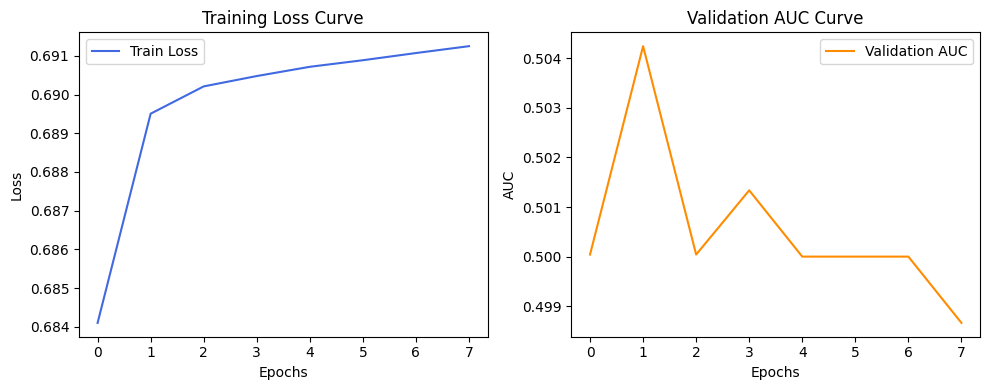

In [41]:
# 1️. Training & Validation Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss", color='royalblue')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Training Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["val_auc"], label="Validation AUC", color='darkorange')
plt.xlabel("Epochs"); plt.ylabel("AUC"); plt.legend(); plt.title("Validation AUC Curve")
plt.tight_layout()
plt.savefig("phase3_loss_auc.png", dpi=200)
print("[INFO] Saved: phase3_loss_auc.png")

[INFO] Computing per-class AUC...
[INFO] Saved: phase3_perclass.png


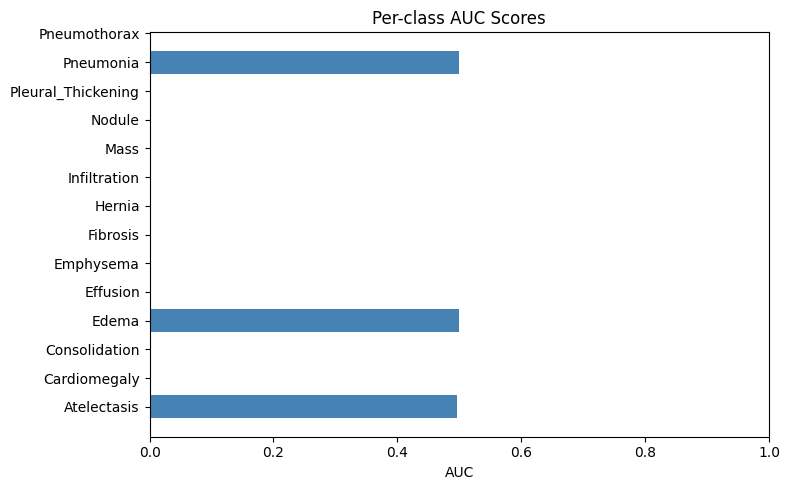

In [42]:
# 2️. Per-class AUC
print("[INFO] Computing per-class AUC...")
final_probs = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(cfg.DEVICE)
        logits = head(xb).detach().cpu().numpy()
        final_probs.append(logits)
final_probs = 1 / (1 + np.exp(-np.concatenate(final_probs)))  # sigmoid

aucs = compute_auc(val_labels, final_probs)
plt.figure(figsize=(8,5))
plt.barh(list(aucs.keys()), list(aucs.values()), color='steelblue')
plt.xlim(0,1); plt.xlabel("AUC"); plt.title("Per-class AUC Scores")
plt.tight_layout(); plt.savefig("phase3_perclass.png", dpi=200)
print("[INFO] Saved: phase3_perclass.png")

[INFO] Saved: phase3_calibration.png


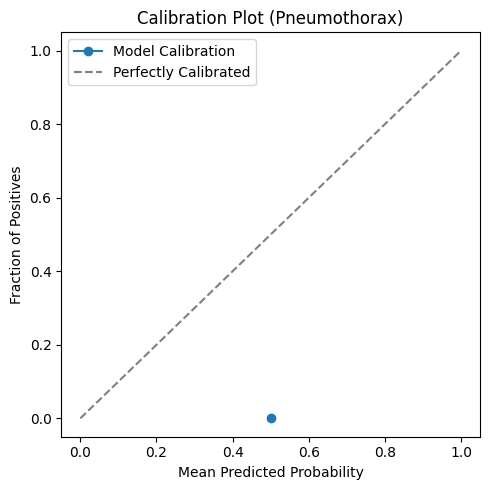

In [43]:
# 3️. Calibration Curve
sel = "Pneumothorax" if "Pneumothorax" in cfg.TARGET_COLUMNS else cfg.TARGET_COLUMNS[0]
i = cfg.TARGET_COLUMNS.index(sel)
frac_pos, mean_pred = calibration_curve(val_labels[:, i], final_probs[:, i], n_bins=10)
plt.figure(figsize=(5,5))
plt.plot(mean_pred, frac_pos, 'o-', label='Model Calibration')
plt.plot([0,1],[0,1],'--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(); plt.title(f"Calibration Plot ({sel})")
plt.tight_layout(); plt.savefig("phase3_calibration.png", dpi=200)
print("[INFO] Saved: phase3_calibration.png")

[INFO] Generating example predictions...
[INFO] ✅ Phase 3 Visualizations complete. All plots saved.


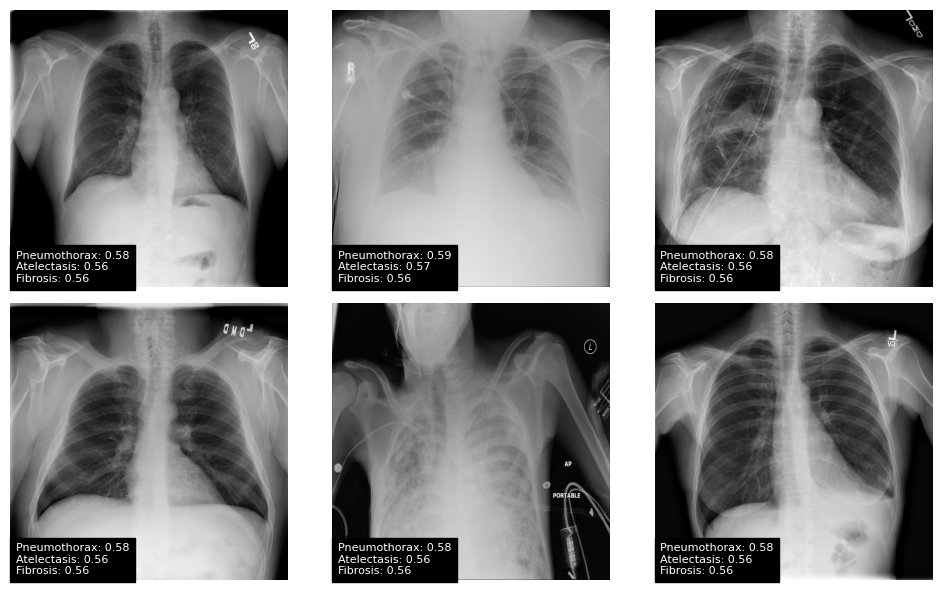

In [44]:
# 4️. Example Predictions
print("[INFO] Generating example predictions...")
idxs = np.random.choice(len(val_df), 6, replace=False)
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for j, idx in enumerate(idxs):
    img_path = val_df.iloc[idx]["image_path"]
    img = Image.open(img_path).convert("RGB")
    axs[j//3, j%3].imshow(img); axs[j//3, j%3].axis("off")

    x = transform(img).unsqueeze(0).to(cfg.DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(head(backbone(x))).detach().cpu().numpy()[0]

    top = np.argsort(prob)[-3:][::-1]
    s = "\n".join([f"{cfg.TARGET_COLUMNS[k]}: {prob[k]:.2f}" for k in top])
    axs[j//3, j%3].text(0.02, 0.02, s, fontsize=8, color="white",
                        backgroundcolor="black", transform=axs[j//3, j%3].transAxes)

plt.tight_layout()
plt.savefig("phase3_examples.png", dpi=200)
print("[INFO] ✅ Phase 3 Visualizations complete. All plots saved.")